In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85%; }</style>"))

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import os
import string
import warnings
import gensim
import numpy as np
import pandas as pd
import gensim
import warnings
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import nltk
from nltk.corpus import wordnet as wn
from collections import defaultdict
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('averaged_perceptron_tagger')
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
import numpy
from gensim.models.doc2vec import TaggedDocument
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

%matplotlib inline

In [3]:
# Step 1: Download the data using wget commands
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
text_data = pd.read_csv('data/full_dataset/goemotions_1.csv')

In [ ]:
text_data.shape

(70000, 37)

In [ ]:
text_data.describe()

,created_utc,rater_id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
count,7.000000e+04,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.547656e+09,37.526686,0.080671,0.044014,0.036986,0.063471,0.084686,0.028400,0.035300,0.046671,...,0.039214,0.008543,0.041243,0.006457,0.040957,0.006457,0.012129,0.031329,0.025800,0.263186
std,7.700606e+05,23.039283,0.272332,0.205128,0.188728,0.243811,0.278415,0.166114,0.184538,0.210936,...,0.194106,0.092033,0.198853,0.080097,0.198192,0.080097,0.109461,0.174205,0.158539,0.440365
min,1.546301e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.546990e+09,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.547660e+09,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.548312e+09,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.548979e+09,81.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
text_data.rename(columns={0:'Text'}, inplace=True)
text_data.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Example: Renaming a column
text_data.rename(columns=lambda x: x.strip(), inplace=True)  # Removes any extra whitespace in column names


In [ ]:
# Step 1: Access the first column, which has the text data
sentence_tokenized = text_data.iloc[:, 0].to_list()

# Step 2: Display the first 20 items to verify
print(sentence_tokenized[:20])


['That game hurt.', ' >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of "grouping" ', "You do right, if you don't care then fuck 'em!", 'Man I love reddit.', '[NAME] was nowhere near them, he was by the Falcon. ', 'Right? Considering it’s such an important document, I should know the damned thing backwards and forwards... thanks again for the help!', "He isn't as big, but he's still quite popular. I've heard the same thing about his content. Never watched him much.", "That's crazy; I went to a super [RELIGION] high school and I think I can remember 2 girls the entire 4 years that became teen moms.", "that's adorable asf", '"Sponge Blurb Pubs Quaw Haha GURR ha AAa!" finale is too real', "I have, and now that you mention it, I think that's what triggered my nostalgia. ", "I wanted to downvote this, but it's not your fault homie.", "BUT IT'S HER TURN! /s", 'That is odd.', 'Build a wall? /jk', "I appreciate it, that's good to

In [ ]:
def customWordTokenizer(sentence):
    tokens = sentence.split()
    return tokens

In [ ]:
import nltk
nltk.download('punkt')  # Download necessary data for tokenization if using nltk

# Example custom tokenizer (replace with your actual tokenizer if different)
def customWordTokenizer(text):
    return nltk.word_tokenize(text)

# Step 1: Rename the first column to 'Text' (optional)
text_data.rename(columns={text_data.columns[0]: 'Text'}, inplace=True)

# Step 2: Apply the custom tokenizer function to the 'Text' column
text_data['tokens'] = text_data['Text'].apply(customWordTokenizer)

# Step 3: Display the resulting DataFrame with 'Text' and 'tokens' columns
print(text_data[['Text', 'tokens']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                                Text  \
0                                    That game hurt.   
1   >sexuality shouldn’t be a grouping category I...   
2     You do right, if you don't care then fuck 'em!   
3                                 Man I love reddit.   
4  [NAME] was nowhere near them, he was by the Fa...   

                                              tokens  
0                              [That, game, hurt, .]  
1  [>, sexuality, shouldn, ’, t, be, a, grouping,...  
2  [You, do, right, ,, if, you, do, n't, care, th...  
3                          [Man, I, love, reddit, .]  
4  [[, NAME, ], was, nowhere, near, them, ,, he, ...  


In [ ]:
def stemFunction(token_list):
    txt_list = []
    for i in token_list:
        txt = stemmer1.stem(i)
        txt_list.append(txt)
    txt_list = " ".join(txt_list)
    return txt_list

In [ ]:
stemmer1 = PorterStemmer()
text_data['stemm'] = text_data["tokens"].apply(stemFunction)
text_data[['Text','tokens','stemm']].head()

,Text,tokens,stemm
0,That game hurt.,"[That, game, hurt, .]",that game hurt .
1,>sexuality shouldn’t be a grouping category I...,"[>, sexuality, shouldn, ’, t, be, a, grouping,...",> sexual shouldn ’ t be a group categori it ma...
2,"You do right, if you don't care then fuck 'em!","[You, do, right, ,, if, you, do, n't, care, th...","you do right , if you do n't care then fuck 'em !"
3,Man I love reddit.,"[Man, I, love, reddit, .]",man i love reddit .
4,"[NAME] was nowhere near them, he was by the Fa...","[[, NAME, ], was, nowhere, near, them, ,, he, ...","[ name ] wa nowher near them , he wa by the fa..."


In [ ]:
def lemmaFunction(token_list):
    txt_list = []
    for i in token_list:
        txt = lemmatizer1.lemmatize(i)
        txt_list.append(txt.lower())
    txt_list = " ".join(txt_list)
    return txt_list

In [ ]:
lemmatizer1 = WordNetLemmatizer()
text_data['lemma'] = text_data["tokens"].apply(lemmaFunction)
text_data[['Text','tokens','lemma']].head()

,Text,tokens,lemma
0,That game hurt.,"[That, game, hurt, .]",that game hurt .
1,>sexuality shouldn’t be a grouping category I...,"[>, sexuality, shouldn, ’, t, be, a, grouping,...",> sexuality shouldn ’ t be a grouping category...
2,"You do right, if you don't care then fuck 'em!","[You, do, right, ,, if, you, do, n't, care, th...","you do right , if you do n't care then fuck 'em !"
3,Man I love reddit.,"[Man, I, love, reddit, .]",man i love reddit .
4,"[NAME] was nowhere near them, he was by the Fa...","[[, NAME, ], was, nowhere, near, them, ,, he, ...","[ name ] wa nowhere near them , he wa by the f..."


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def stopwords_remover(sentence, stopW):
    words = sentence.split()
    rr = []
    for word in words:
        if word not in (stopW):
            rr.append(word)
        r = re.sub("[^a-z #@]", "", " ".join(rr))
        input_txt = re.sub("@[\w]*", "", r)


    return input_txt

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords resource
nltk.download('stopwords')

# Step 1: Define the stop words set
stop_words = set(stopwords.words('english'))

# Step 2: Define the function to remove stop words
def stopwords_remover(tokens, stopW):
    return [word for word in tokens if word.lower() not in stopW]

# Step 3: Apply the function to the 'lemma' column (assuming 'lemma' is already a list of lemmatized tokens)
text_data['nltk_stop_word_removed'] = text_data['lemma'].apply(lambda x: stopwords_remover(x, stopW=stop_words))

# Step 4: Display the result
print(text_data[['Text', 'lemma', 'nltk_stop_word_removed']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                Text  \
0                                    That game hurt.   
1   >sexuality shouldn’t be a grouping category I...   
2     You do right, if you don't care then fuck 'em!   
3                                 Man I love reddit.   
4  [NAME] was nowhere near them, he was by the Fa...   

                                               lemma  \
0                                   that game hurt .   
1  > sexuality shouldn ’ t be a grouping category...   
2  you do right , if you do n't care then fuck 'em !   
3                                man i love reddit .   
4  [ name ] wa nowhere near them , he wa by the f...   

                              nltk_stop_word_removed  
0                     [h,  , g, e,  , h, u, r,  , .]  
1  [>,  , e, x, u, l,  , h, u, l, n,  , ’,  ,  , ...  
2  [u,  ,  , r, g, h,  , ,,  , f,  , u,  ,  , n, ...  
3                  [n,  ,  , l, v, e,  , r, e,  , .]  
4  [[,  , n, e,  , ],  , w,  , n, w, h, e, r, e, ..

In [ ]:
custom_stops_words = ['.', 'ha', 'ja', 'aa', 'rr']
custom_stops_words.extend(stop_words)
print(custom_stops_words)

['.', 'ha', 'ja', 'aa', 'rr', 'doing', 'a', 'do', 'the', 'will', 'but', 'between', 'under', "couldn't", 'does', 'weren', 'further', 'couldn', 'most', 'yourselves', 'you', "she's", 'as', 'we', 'did', 'if', "hasn't", 'your', 'it', 't', 'same', 'hers', 'him', 'in', "that'll", 'again', 'being', 'when', 'more', 've', 'any', 'doesn', 'y', 'only', "mustn't", 'own', 'nor', 's', 'i', 'itself', 'those', 'haven', 'should', 'ain', 'shouldn', 'against', 'on', "you're", 'how', 'these', 'ourselves', 'wouldn', "hadn't", 'been', 'over', 'until', 'ours', 'after', 'with', 'then', 'because', 'some', 'didn', "shan't", "you'd", 'no', 'his', 'down', 'here', 'aren', 'just', 'not', 'or', 'once', 'before', 'each', 'very', 'into', 'for', 'whom', "weren't", 'an', 'while', 'having', 'there', 'about', 'himself', 'our', 'hasn', 'themselves', 'by', 'now', 'during', 'won', 'that', 'from', "shouldn't", "haven't", 'both', 'wasn', 'can', 'few', 'of', 'which', "don't", 'my', 'am', 'and', 'don', 'theirs', 'needn', 'this', 

In [ ]:
text_data['custom_stop_word'] = text_data['lemma'].apply(stopwords_remover,stopW=custom_stops_words)
text_data[['Text','lemma', 'custom_stop_word']].head()

,Text,lemma,custom_stop_word
0,That game hurt.,that game hurt .,"[h, , g, e, , h, u, r, ]"
1,>sexuality shouldn’t be a grouping category I...,> sexuality shouldn ’ t be a grouping category...,"[>, , e, x, u, l, , h, u, l, n, , ’, , , ..."
2,"You do right, if you don't care then fuck 'em!","you do right , if you do n't care then fuck 'em !","[u, , , r, g, h, , ,, , f, , u, , , n, ..."
3,Man I love reddit.,man i love reddit .,"[n, , , l, v, e, , r, e, ]"
4,"[NAME] was nowhere near them, he was by the Fa...","[ name ] wa nowhere near them , he wa by the f...","[[, , n, e, , ], , w, , n, w, h, e, r, e, ..."


In [ ]:
notepad_stops_words = ['lol', 'a', 'kk']
# notepad_stops_words.extend(custom_stops_words)
with open(r'notepad_stops_words.txt', 'w') as fp:
    for item in notepad_stops_words:
        fp.write(f"{item}\n")

In [ ]:
notepad_stops_words = []

# open file and read the content in a list
with open(r'notepad_stops_words.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        notepad_stops_words.append(x)

In [ ]:
notepad_stops_words = ['lol', 'a', 'kk']
notepad_stops_words.extend(custom_stops_words)
print(notepad_stops_words)

['lol', 'a', 'kk', '.', 'ha', 'ja', 'aa', 'rr', 'doing', 'a', 'do', 'the', 'will', 'but', 'between', 'under', "couldn't", 'does', 'weren', 'further', 'couldn', 'most', 'yourselves', 'you', "she's", 'as', 'we', 'did', 'if', "hasn't", 'your', 'it', 't', 'same', 'hers', 'him', 'in', "that'll", 'again', 'being', 'when', 'more', 've', 'any', 'doesn', 'y', 'only', "mustn't", 'own', 'nor', 's', 'i', 'itself', 'those', 'haven', 'should', 'ain', 'shouldn', 'against', 'on', "you're", 'how', 'these', 'ourselves', 'wouldn', "hadn't", 'been', 'over', 'until', 'ours', 'after', 'with', 'then', 'because', 'some', 'didn', "shan't", "you'd", 'no', 'his', 'down', 'here', 'aren', 'just', 'not', 'or', 'once', 'before', 'each', 'very', 'into', 'for', 'whom', "weren't", 'an', 'while', 'having', 'there', 'about', 'himself', 'our', 'hasn', 'themselves', 'by', 'now', 'during', 'won', 'that', 'from', "shouldn't", "haven't", 'both', 'wasn', 'can', 'few', 'of', 'which', "don't", 'my', 'am', 'and', 'don', 'theirs',

In [ ]:
text_data['notepad_stop_word'] = text_data['lemma'].apply(stopwords_remover,stopW=custom_stops_words)
text_data[['Text','lemma', 'notepad_stop_word']].head()

,Text,lemma,notepad_stop_word
0,That game hurt.,that game hurt .,"[h, , g, e, , h, u, r, ]"
1,>sexuality shouldn’t be a grouping category I...,> sexuality shouldn ’ t be a grouping category...,"[>, , e, x, u, l, , h, u, l, n, , ’, , , ..."
2,"You do right, if you don't care then fuck 'em!","you do right , if you do n't care then fuck 'em !","[u, , , r, g, h, , ,, , f, , u, , , n, ..."
3,Man I love reddit.,man i love reddit .,"[n, , , l, v, e, , r, e, ]"
4,"[NAME] was nowhere near them, he was by the Fa...","[ name ] wa nowhere near them , he wa by the f...","[[, , n, e, , ], , w, , n, w, h, e, r, e, ..."


In [ ]:
text_data['notepad_stop_word'] = text_data['lemma'].apply(stopwords_remover,stopW=custom_stops_words)
text_data[['Text','lemma', 'notepad_stop_word']].head()

,Text,lemma,notepad_stop_word
0,That game hurt.,that game hurt .,"[h, , g, e, , h, u, r, ]"
1,>sexuality shouldn’t be a grouping category I...,> sexuality shouldn ’ t be a grouping category...,"[>, , e, x, u, l, , h, u, l, n, , ’, , , ..."
2,"You do right, if you don't care then fuck 'em!","you do right , if you do n't care then fuck 'em !","[u, , , r, g, h, , ,, , f, , u, , , n, ..."
3,Man I love reddit.,man i love reddit .,"[n, , , l, v, e, , r, e, ]"
4,"[NAME] was nowhere near them, he was by the Fa...","[ name ] wa nowhere near them , he wa by the f...","[[, , n, e, , ], , w, , n, w, h, e, r, e, ..."


In [ ]:
def generate_N_grams(text,ngram):
    temp=zip(*[text[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

In [ ]:
ngram_value = 1
text_data[f'{ngram_value}_gram'] = text_data["tokens"].apply(generate_N_grams, ngram=ngram_value)
text_data[['Text','tokens',f'{ngram_value}_gram']].head()

,Text,tokens,1_gram
0,That game hurt.,"[That, game, hurt, .]","[That, game, hurt, .]"
1,>sexuality shouldn’t be a grouping category I...,"[>, sexuality, shouldn, ’, t, be, a, grouping,...","[>, sexuality, shouldn, ’, t, be, a, grouping,..."
2,"You do right, if you don't care then fuck 'em!","[You, do, right, ,, if, you, do, n't, care, th...","[You, do, right, ,, if, you, do, n't, care, th..."
3,Man I love reddit.,"[Man, I, love, reddit, .]","[Man, I, love, reddit, .]"
4,"[NAME] was nowhere near them, he was by the Fa...","[[, NAME, ], was, nowhere, near, them, ,, he, ...","[[, NAME, ], was, nowhere, near, them, ,, he, ..."


In [ ]:
ngram_value = 2
text_data[f'{ngram_value}_gram'] = text_data["tokens"].apply(generate_N_grams, ngram=ngram_value)
text_data[['Text','tokens',f'{ngram_value}_gram']].head()


,Text,tokens,2_gram
0,That game hurt.,"[That, game, hurt, .]","[That game, game hurt, hurt .]"
1,>sexuality shouldn’t be a grouping category I...,"[>, sexuality, shouldn, ’, t, be, a, grouping,...","[> sexuality, sexuality shouldn, shouldn ’, ’ ..."
2,"You do right, if you don't care then fuck 'em!","[You, do, right, ,, if, you, do, n't, care, th...","[You do, do right, right ,, , if, if you, you ..."
3,Man I love reddit.,"[Man, I, love, reddit, .]","[Man I, I love, love reddit, reddit .]"
4,"[NAME] was nowhere near them, he was by the Fa...","[[, NAME, ], was, nowhere, near, them, ,, he, ...","[[ NAME, NAME ], ] was, was nowhere, nowhere n..."


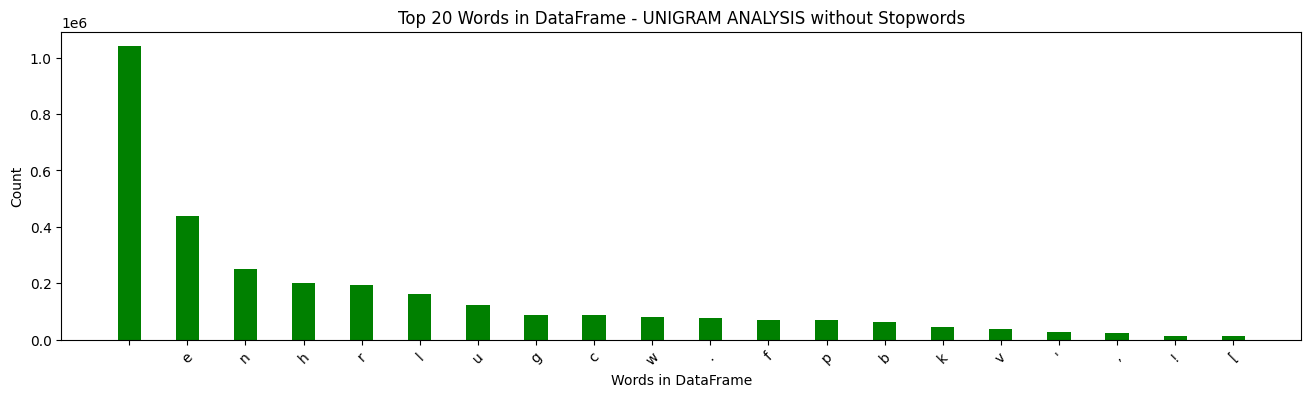

In [ ]:
# Replace 'notepad_stop_word_tokens' with the correct column name
# Assuming 'nltk_stop_word_removed' is the column with tokens without stop words
unigram_textValues = defaultdict(int)

# Count unigrams in the 'nltk_stop_word_removed' column
for text in text_data['nltk_stop_word_removed'].to_list():
    for word in generate_N_grams(text, ngram=1):  # generate_N_grams with ngram=1 for unigrams
        unigram_textValues[word] += 1

# Convert to DataFrame and sort by frequency
df_unigram = pd.DataFrame(sorted(unigram_textValues.items(), key=lambda x: x[1], reverse=True), columns=['Word', 'Count'])

# Extract top 20 unigrams for plotting
nud1 = df_unigram['Word'][:20]
nud2 = df_unigram['Count'][:20]

# Plotting
plt.figure(figsize=(16, 4))
plt.bar(nud1, nud2, color='green', width=0.4)
plt.xlabel("Words in DataFrame")
plt.ylabel("Count")
plt.title("Top 20 Words in DataFrame - UNIGRAM ANALYSIS without Stopwords")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129323 (\N{FACE WITH FINGER COVERING CLOSED LIPS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128134 (\N{FACE MASSAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129402 (\N{FACE WITH PLEADING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127467 (\N{REGIONAL INDICATOR SYMBOL LETTER F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local

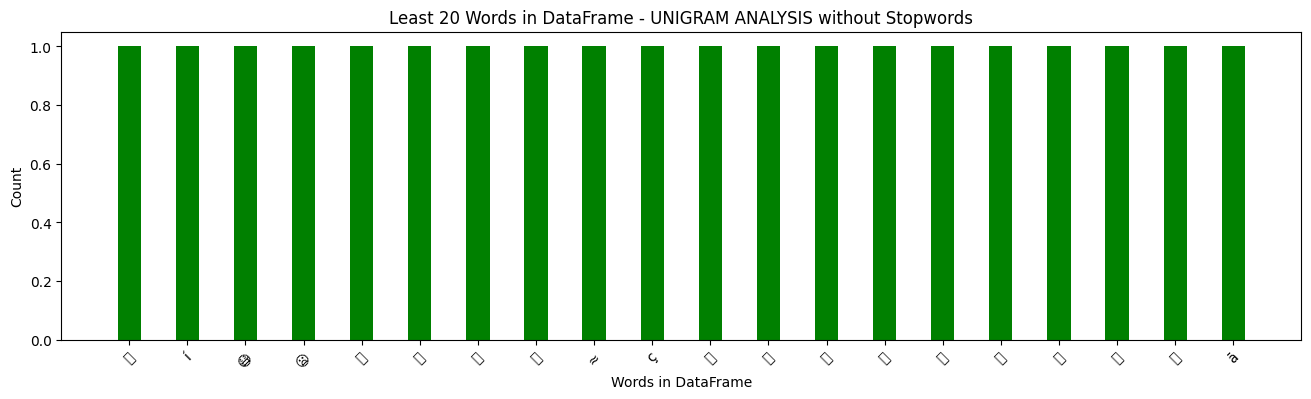

In [ ]:
# Extract the least 20 unigrams for plotting
nud1 = df_unigram['Word'][-20:]
nud2 = df_unigram['Count'][-20:]

# Plotting
plt.figure(figsize=(16, 4))
plt.bar(nud1, nud2, color='green', width=0.4)
plt.xlabel("Words in DataFrame")
plt.ylabel("Count")
plt.title("Least 20 Words in DataFrame - UNIGRAM ANALYSIS without Stopwords")
plt.xticks(rotation=45)
plt.show()


In [ ]:
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="neutral"
unigram_textValues=defaultdict(int)
for text in text_data['tokens'].to_list():
    for word in generate_N_grams(text, ngram=1):
        unigram_textValues[word]+=1

In [ ]:
#focus on more frequently occuring words for every sentiment=>
#sort in DO wrt 2nd column in each of positiveValues,negativeValues and neutralValues
df_unigram=pd.DataFrame(sorted(unigram_textValues.items(),key=lambda x:x[1],reverse=True))

In [ ]:
nud1=df_unigram[0][:20]
nud2=df_unigram[1][:20]


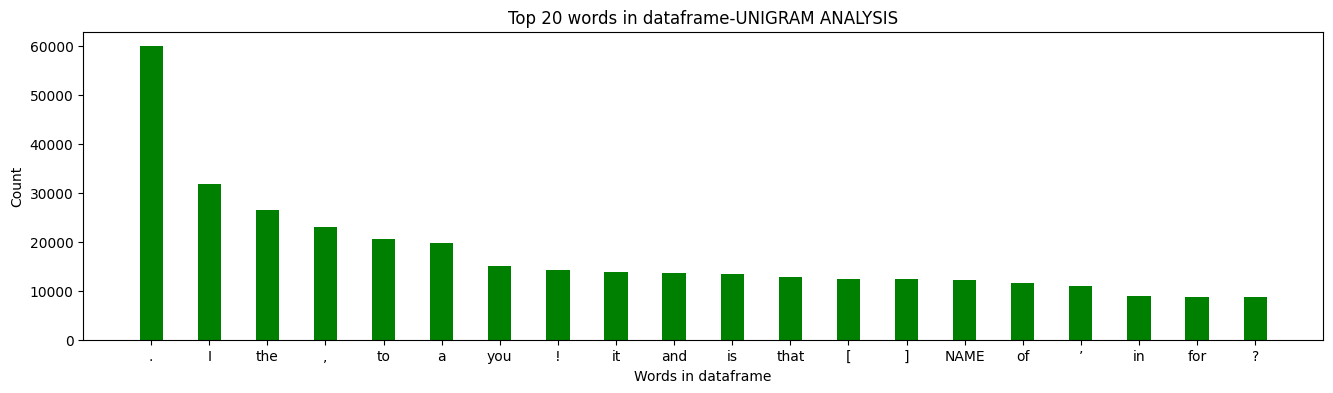

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(nud1, nud2, color ='green', width = 0.4)
plt.xlabel("Words in dataframe")
plt.ylabel("Count")
plt.title("Top 20 words in dataframe-UNIGRAM ANALYSIS")
plt.show()



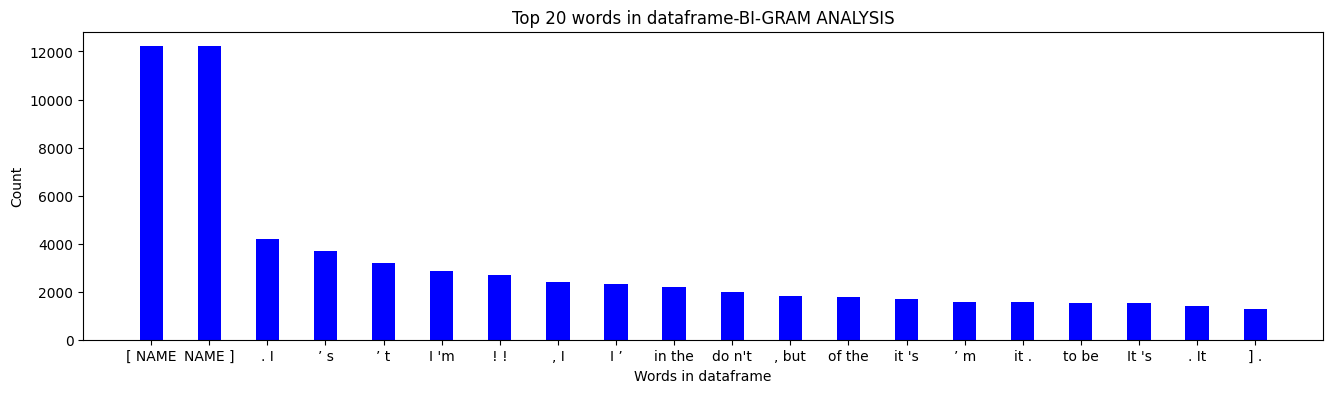

In [ ]:
bigram_textValues=defaultdict(int)
for text in text_data['tokens'].to_list():
    for word in generate_N_grams(text, ngram=2):
        bigram_textValues[word]+=1
df_bigram=pd.DataFrame(sorted(bigram_textValues.items(),key=lambda x:x[1],reverse=True))
nud1=df_bigram[0][:20]
nud2=df_bigram[1][:20]
plt.figure(1,figsize=(16,4))
plt.bar(nud1, nud2, color ='blue', width = 0.4)
plt.xlabel("Words in dataframe")
plt.ylabel("Count")
plt.title("Top 20 words in dataframe-BI-GRAM ANALYSIS")
plt.show()

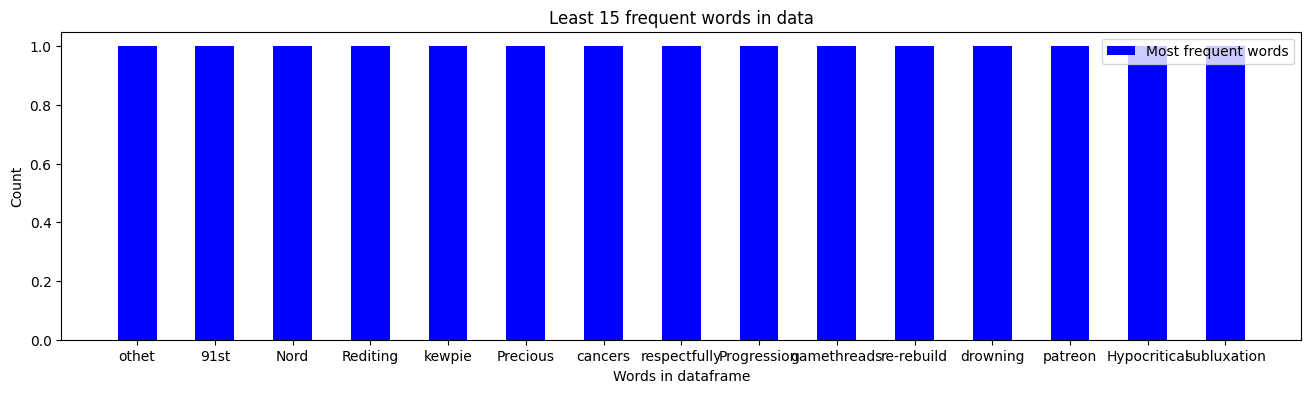

In [ ]:
df_neutral=pd.DataFrame(sorted(unigram_textValues.items(),key=lambda x:x[1]))
nud1=df_neutral[0][:15]
nud2=df_neutral[1][:15]
plt.figure(1,figsize=(16,4))
plt.bar(nud1, nud2, color ='blue', width = 0.5)
plt.xlabel("Words in dataframe")
plt.ylabel("Count")
plt.title("Least 15 frequent words in data")
plt.legend(['Most frequent words'])
plt.show()

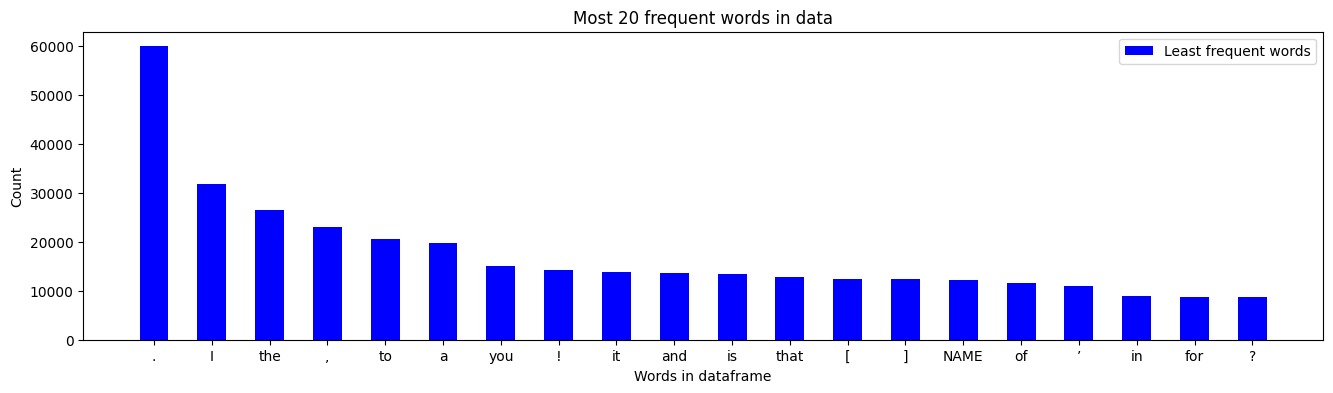

In [ ]:
df_unigram==pd.DataFrame(sorted(unigram_textValues.items(),key=lambda x:x[1],reverse=True))
nud1=df_unigram[0][:20]
nud2=df_unigram[1][:20]
plt.figure(1,figsize=(16,4))
plt.bar(nud1, nud2, color ='blue', width = 0.5)
plt.xlabel("Words in dataframe")
plt.ylabel("Count")
plt.title("Most 20 frequent words in data")
plt.legend(['Least frequent words'])
plt.show()

In [ ]:
text_list =text_data['notepad_stop_word'].to_list()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure text_list is correctly defined as a list of text data
text_list = text_data['Text'].tolist()

# Initialize and fit TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text_list)

# Print all unique words (features)
print("All Unique Words:")
print(vectorizer.get_feature_names_out())



All Unique Words:
['00' '000' '00001' ... '개인면허' '카니발' 'ﾉωﾉ']


In [ ]:
print("Vectors")
print(vectorizer.transform(text_list))

Vectors
  (0, 9896)	0.5853621013992822
  (0, 11693)	0.7583730249605866
  (0, 23526)	0.2867430300069137
  (1, 2545)	0.0995363979105411
  (1, 4092)	0.28500006651611054
  (1, 6468)	0.23810085039369885
  (1, 6894)	0.1809348881016302
  (1, 9219)	0.24857603205808787
  (1, 9684)	0.12492214637714635
  (1, 10587)	0.5862730015004654
  (1, 11944)	0.20961271729623113
  (1, 12665)	0.14394032306054544
  (1, 14285)	0.15064714038169658
  (1, 16268)	0.08160149232417543
  (1, 16606)	0.3242082549244336
  (1, 18025)	0.256389231579813
  (1, 20871)	0.2691726045678998
  (1, 21132)	0.2048690599202292
  (1, 21735)	0.10108341472070044
  (1, 23533)	0.0599952108908613
  (1, 26483)	0.07230347476947156
  (2, 3993)	0.39181899128759945
  (2, 7259)	0.26207001493114135
  (2, 7332)	0.2539406331783164
  (2, 7959)	0.4855059353061882
  :	:
  (69997, 1717)	0.29718115229616315
  (69997, 3878)	0.15795046489041614
  (69997, 5444)	0.41923572418773036
  (69997, 5788)	0.4045907012246308
  (69997, 8568)	0.3015469089698486
  (69997

In [ ]:
#instantiate CountVectorizer()
cv=CountVectorizer()
# this steps generates word counts for the words of corpus
word_count_vector=cv.fit_transform(text_list)

In [ ]:
word_count_vector.shape

(70000, 26611)

In [ ]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [ ]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"])
# sort ascending
df_idf.sort_values(by=['idf_weights'])

,idf_weights
the,2.121267
to,2.378284
it,2.544668
you,2.556453
that,2.598724
...,...
futurescope,11.463118
fuuuuuuuck,11.463118
fuuuuuuuuck,11.463118
furthermore,11.463118


In [ ]:
# count matrix
count_vector=cv.transform(text_list)
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [ ]:
feature_names = cv.get_feature_names_out()
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
hurt,0.758373
game,0.585362
that,0.286743
00,0.000000
pm,0.000000
pnr,0.000000
pnp,0.000000
pneumonia,0.000000
pneumatic,0.000000
pms,0.000000


In [ ]:
tf_idf_feature_names = cv.get_feature_names_out()
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=tf_idf_feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
hurt,0.758373
game,0.585362
that,0.286743
00,0.000000
pm,0.000000
pnr,0.000000
pnp,0.000000
pneumonia,0.000000
pneumatic,0.000000
pms,0.000000


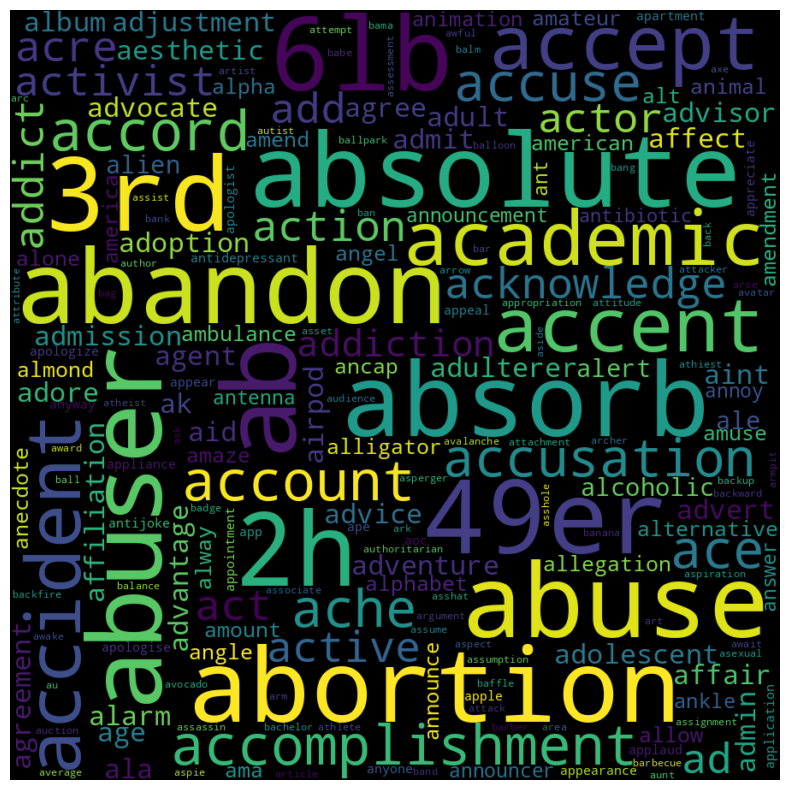

In [ ]:
all_words = ' '.join([text for text in tf_idf_feature_names])
wordcloud = WordCloud(width=900, height=900, random_state=21, max_font_size=120).generate(all_words)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
feature_names = cv.get_feature_names_out()
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
#print the scores
vectors = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["vectors"])
vectors.sort_values(by=["vectors"],ascending=False).head(10)

,vectors
hurt,0.758373
game,0.585362
that,0.286743
00,0.000000
pm,0.000000
pnr,0.000000
pnp,0.000000
pneumonia,0.000000
pneumatic,0.000000
pms,0.000000


In [ ]:
def word_extraction(sentence):
  ignore = ['a', "the", "is"]
  words = re.sub("[^\w]", " ",  sentence).split()
  cleaned_text = [w.lower() for w in words if w not in ignore]
  return cleaned_text
def tokenize(sentences):
  words = []
  for sentence in sentences:
    w = word_extraction(sentence)
    words.extend(w)
    words = sorted(list(set(words)))
  return words
def generate_bow(allsentences):
  vocab = tokenize(allsentences)
  print("Word List for Document \n{0} \n".format(vocab));
  for sentence in allsentences:
    words = word_extraction(sentence)
    bag_vector = numpy.zeros(len(vocab))
    for w in words:
      for i,word in enumerate(vocab):
        if word == w:
          bag_vector[i] += 1
          print("{0}\n{1}\n".format(sentence,numpy.array(bag_vector)))
generate_bow(text_data["Text"].tolist()[:20])

Word List for Document 
['1', '2', '4', '91st', 'aaa', 'able', 'about', 'adorable', 'again', 'along', 'an', 'and', 'any', 'apply', 'appreciate', 'as', 'asf', 'assault', 'backwards', 'be', 'became', 'big', 'blurb', 'build', 'but', 'by', 'can', 'care', 'category', 'chance', 'considering', 'content', 'crazy', 'crotch', 'd', 'damned', 'day', 'definition', 'different', 'do', 'document', 'don', 'downvote', 'dude', 'em', 'entire', 'every', 'extra', 'falcon', 'fault', 'finale', 'fits', 'for', 'forwards', 'from', 'fuck', 'game', 'get', 'girl', 'girls', 'good', 'grouping', 'gurr', 'ha', 'haha', 'have', 'he', 'heard', 'help', 'her', 'high', 'him', 'his', 'homie', 'hope', 'hurt', 'i', 'if', 'imo', 'important', 'in', 'isn', 'it', 'jk', 'know', 'knowledge', 'lights', 'll', 'lol', 'love', 'makes', 'man', 'measure', 'mention', 'met', 'moms', 'much', 'my', 'name', 'near', 'never', 'nostalgia', 'not', 'now', 'nowhere', 'odd', 'of', 'one', 'othet', 'photo', 'platform', 'popular', 'ppl', 'pretty', 'pubs',

In [ ]:
def make_label_of_dataset(df,common_words=["data","network","algo","algorithm","system","design","web","business","marketing"] ,column ="Text"):
  classes= {"computer":["data","network","algo","algorithm","system","design","web"],"Business":["business","marketing","advertisements"]}
  labels =  []
  def get_key(val,my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
  for sent in df[column].tolist():
    sent = sent.lower()
    words = sent.split(" ")
    max = 0
    for pos,c_word in enumerate(common_words):
      if words.count(c_word)>max:
        max = words.count(c_word)
        n_word = c_word
      else:
        if (pos==len(common_words)-1) and (max == 0):
          n_word = "Unidentified"
    for pos2,class1 in enumerate(classes.values()):
      if n_word in class1:
        labels.append(get_key(class1,classes))
        break
      else:
        if pos2 ==len(classes)-1:
          labels.append(n_word)
          continue
  df["Labels"] = labels
  return df
new_df = make_label_of_dataset(text_data)

In [ ]:
new_df.loc[new_df["Labels"]=="Business",["Text","Labels"]]

,Text,Labels
651,My dude looks like he's done with this WWE bus...,Business
899,I think some of them expect there to be a cash...,Business
2422,He can’t be like that in that business but it ...,Business
3267,Good viral marketing attempt [NAME]!,Business
3446,It was my impression that Monzo doesn't offer ...,Business
...,...,...
67997,IIRC Tool doesn’t like their stuff on Spotify ...,Business
68473,The moral of the story is obviously you should...,Business
68620,Lmao all these othr trades happened so I think...,Business
68982,Would destroying the business bring them both ...,Business


In [ ]:
new_df.loc[new_df["Labels"]=="computer",["Text","Labels"]]

,Text,Labels
1703,If this data were exportable in CSV format. I ...,computer
1970,Yeah... major design flaw.,computer
2071,I wonder what was stopping that barber using t...,computer
2103,Time to let the justice system run its course.,computer
3060,AV is a system where if you vote for a loser y...,computer
...,...,...
67081,"Seriously. ""Haha british people pronounce some...",computer
68491,If this data were exportable in CSV format. I ...,computer
68752,"Sony, for similar design on generic game contr...",computer
69406,Market ≠ Capitalism Just because something ope...,computer


<ipython-input-68-3ca858d6e78d>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(computer['word_count'], shade=True, color="g").set_title('Kernel Distribution of Number Of words')
<ipython-input-68-3ca858d6e78d>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(unid['word_count'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
<ipython-input-68-3ca858d6e78d>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(busineess['word_count'], shade=True, color="b")


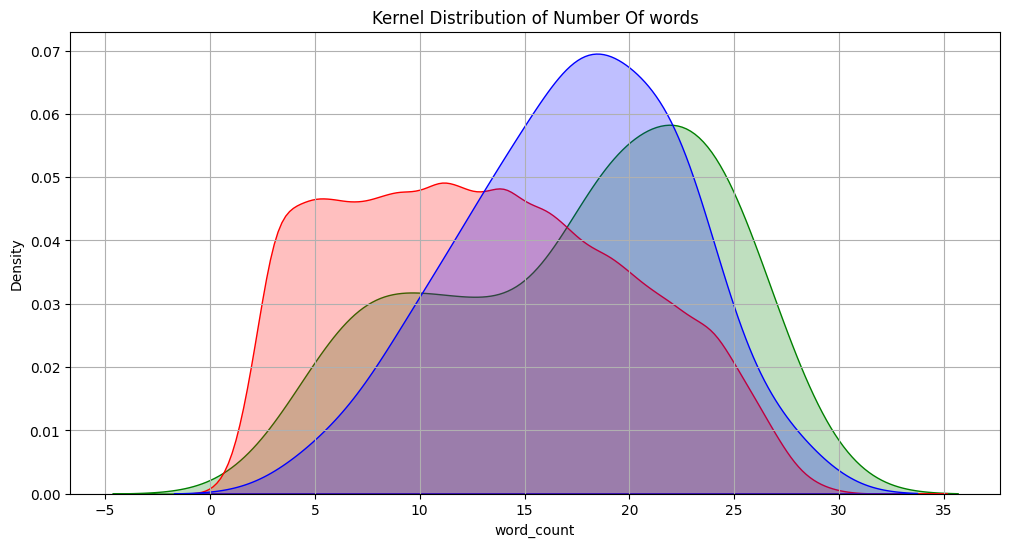

In [ ]:
import seaborn as sns

def make_KDE(df):
  df['word_count'] = df['Text'].apply(lambda x : len(str(x).split(" ")))
  plt.figure(figsize=(12,6))
  computer = new_df.loc[new_df["Labels"]=="computer",["Text",'word_count',"Labels"]]
  busineess = new_df.loc[new_df["Labels"]=="Business",["Text",'word_count',"Labels"]]
  unid = new_df.loc[new_df["Labels"]=="Unidentified",["Text",'word_count',"Labels"]]
  p1=sns.kdeplot(computer['word_count'], shade=True, color="g").set_title('Kernel Distribution of Number Of words')
  p1=sns.kdeplot(unid['word_count'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
  p1=sns.kdeplot(busineess['word_count'], shade=True, color="b")
  plt.grid()
make_KDE(new_df)

In [ ]:
computer = new_df.loc[new_df["Labels"]=="computer",['word_count']]
busineess = new_df.loc[new_df["Labels"]=="Business",['word_count']]
unid = new_df.loc[new_df["Labels"]=="Unidentified",['word_count']]
hist_data = [computer["word_count"] ,busineess["word_count"] ,unid["word_count"] ]
group_labels = ["Computer","Business","Unidentified"]


fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()